# **Data analysis**

## **Training set**

In [1]:
import pandas as pd

In [28]:
neg_cols = ['ID', 'Organism_name', 'Kingdom', 'Sequence_length', 'Transmembrane']
negatives = pd.read_csv('negative_non_redundant.tsv', sep='\t', names=neg_cols)
#negatives.head(10)

In [29]:
pos_cols = ['ID', 'Organism_name', 'Kingdom', 'Sequence_length', 'Signal_peptide']
positives = pd.read_csv('positive_non_redundant.tsv', sep='\t', names=pos_cols)
#positives.head(10)

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## **Comparison between sequence length in positive and negative entries**

In [36]:
negatives['Log_seq_len'] = np.log10(negatives['Sequence_length'])
positives['Log_seq_len'] = np.log10(positives['Sequence_length'])

In [37]:
negatives["Source"] = "negatives"
positives["Source"] = "positives"
training = pd.concat([negatives[['Log_seq_len', 'Source']], positives[['Log_seq_len', 'Source']]], ignore_index=True)

In [38]:
training.head(10)

,Log_seq_len,Source
0,2.621176,negatives
1,2.326336,negatives
2,2.805501,negatives
3,2.731589,negatives
4,2.717671,negatives
5,2.330414,negatives
6,2.707570,negatives
7,2.593286,negatives
8,2.819544,negatives
9,2.356026,negatives


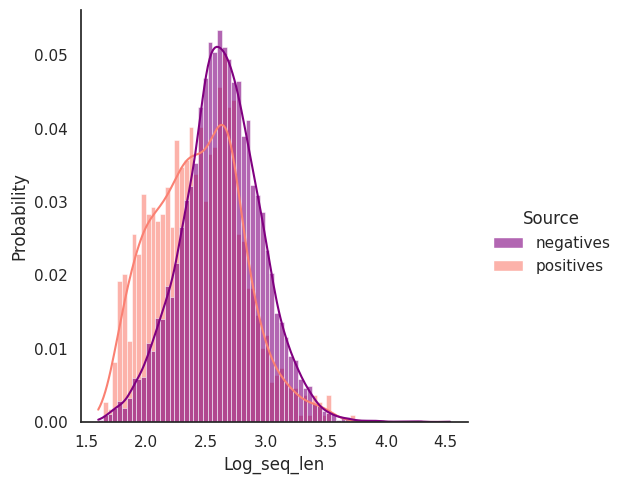

In [54]:
sns.set_theme()
sns.set_theme(context='notebook',
 style='white',
 palette=['purple','salmon'],
 font='sans-serif',
 font_scale=1,
 color_codes=True,
)
sns.displot(data = training, hue='Source', x = 'Log_seq_len', kde = True, common_norm=False, stat='probability', alpha=0.6)
plt.show()

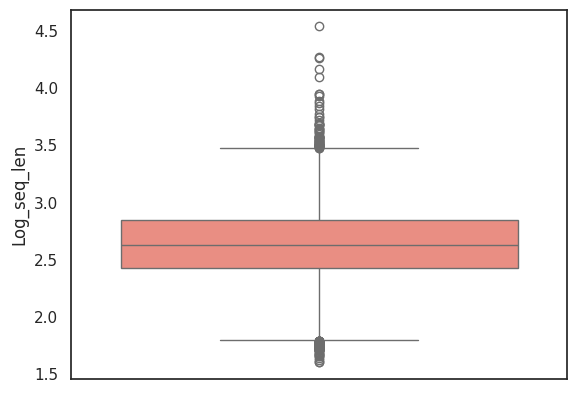

In [55]:
sns.boxplot(data = negatives, y = 'Log_seq_len', color='salmon')
plt.show()

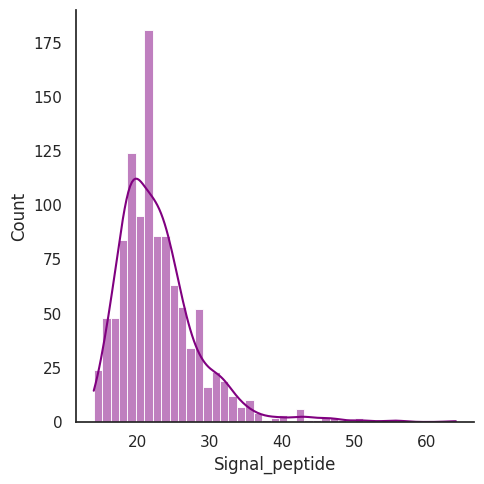

In [56]:
sns.set_theme()
sns.set_theme(context='notebook',
 style='white',
 palette='purple',
 font='sans-serif',
 font_scale=1,
 color_codes=True,
)
sns.displot(data = positives, x = 'Signal_peptide', kde = True)
plt.show()

In [ ]:
sns.boxplot(data = negatives, y = 'Log_seq_len', color='salmon')
plt.show()